## PART I
A workflow for inference on the presence of a target object using an MRF. We designed a toy problem to validate whether target object inference matched our intuitions based on simulated co-occurrence statistics. We intend to compare the output of an exact inference algorithm to the manual calcuation of energy. 

In [395]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from pgmpy.models import MarkovNetwork
from pgmpy.factors.discrete import DiscreteFactor
from pgmpy.inference import VariableElimination, BeliefPropagation
from pgmpy.sampling import GibbsSampling
import daft
import random
import itertools

[[0.  0.5 1.  0.2]
 [0.5 0.  0.2 0.1]
 [1.  0.2 0.  1. ]
 [0.2 0.1 1.  0. ]]


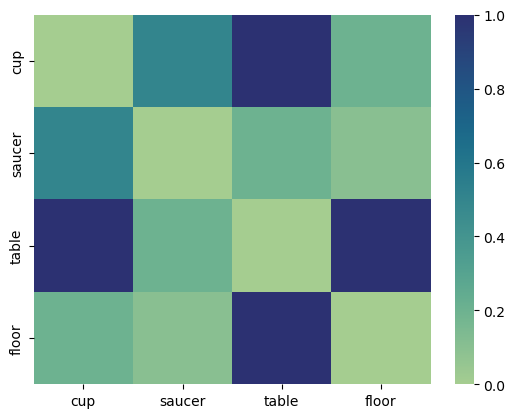

In [396]:
objects = ["cup","saucer","table","floor"]

# counts
cooccur = np.array([[0,5,10,2],
                    [5,0,2,1],
                    [10,2,0,10],
                    [2,1,10,0]])

cooccur = cooccur/np.max(cooccur)

print(cooccur)
sns.heatmap(cooccur,xticklabels=objects,yticklabels=objects,cmap='crest')

#np.fill_diagonal(cooccur,0)
cooccur = pd.DataFrame(cooccur,index=objects,columns=objects)


In [397]:
# instantiate network
G = MarkovNetwork()

# create graph (add nodes and edges)
nodes = objects
edges = list(itertools.combinations(objects,r=2))

G.add_nodes_from(nodes)
G.add_edges_from(edges)

<Axes:>

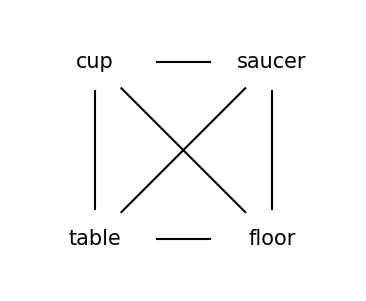

In [398]:
# illustrate graph
pgm = daft.PGM(aspect=2.1, dpi=150, node_unit=1, grid_unit=3, directed=False, node_ec=None)

x = [0, 1, 0, 1]
y = [1, 1, 0, 0]

for i in range(len(nodes)):
    pgm.add_node(nodes[i], nodes[i], x[i], y[i])
    
for i in range(len(edges)):    
    pgm.add_edge(edges[i][0],edges[i][1])
    
pgm.render()

In [399]:
# phi based on Kollar & Roy 2009
def compatibility(edge,cooccur):
    
    tt = cooccur.loc[edge[0],edge[1]] / np.sum(cooccur.loc[edge[0],:])
    ft = (np.sum(cooccur.loc[:,edge[1]])-cooccur.loc[edge[0],edge[1]]) / (np.sum(np.triu(np.asarray(cooccur)))-np.sum(cooccur.loc[edge[0],:]))
    tf = 1 - tt
    ff = 1 - ft

    phi = np.reshape([ff, ft, tf, tt],(2,2))
    
    return phi

In [400]:
# create factors
for e in G.edges():
    factor = DiscreteFactor(e, [2, 2], compatibility(e,cooccur))
    G.add_factors(factor)

In [401]:
def mrf_approx_infer(nodes, cooccur, evidence={}, iterations=1000):

    # total energy calculation
    E = np.zeros(iterations)

    # pregenerate states
    S = pd.DataFrame(np.random.randint(low = 0, high = 2, size = (iterations,len(nodes))),columns = nodes)

    if (len(evidence) > 0):
        for idx, key in enumerate(list(evidence.items())):
            S[key[0]] = key[1]

    # start iterations loop
    for i in range(iterations):
        
        state = S.iloc[i]
        energy = []
        edges = list(itertools.combinations(nodes,r=2))

        for e in range(len(edges)):
        
            psi = compatibility(edges[e],cooccur)[state[edges[e][0]],state[edges[e][1]]]
            energy.append(psi)

        E[i] = np.sum(np.log(energy))

    return S.iloc[np.argmax(E)] # print state with maximum energy 


In [406]:
def mrf_exact_infer(nodes, evidence={}, iterations=1000):

    G_infer = BeliefPropagation(G)
    node_states = pd.DataFrame(np.zeros((1,len(nodes))),index=['state'],columns=nodes)
    
    for i in range(len(list(evidence.keys()))):
        node_states[list(evidence.keys())[i]] = list(evidence.values())[i]
        nodes.remove(list(evidence.keys())[i])

    for n in nodes:
        G_prob = G_infer.query(variables=[n], evidence=evidence)
        node_states[n] = np.argmax((G_prob.values))

    return print(node_states.T)

In [407]:
# mrf exact inference with package
nodes = objects.copy()
evidence = {'saucer': 1}

mrf_exact_infer(nodes,evidence)

        state
cup         1
saucer      1
table       0
floor       0


In [314]:
# mrf approximate inference custom
nodes = objects.copy()
evidence = {'saucer': 1}

mrf_approx_infer(nodes,cooccur,evidence) 

cup       1
saucer    0
table     1
floor     0
spoon     0
fork      0
Name: 1, dtype: int64

## PART II
 
Below attempts another toy problem with additional objects to verify custom algorithm.

In [470]:
all_objs = pd.read_excel('post_objects.xlsx')
full_objects = []
n = 15

for i in range(n):
    full_objects.append(all_objs.iloc[i][0][6:])

<AxesSubplot:>

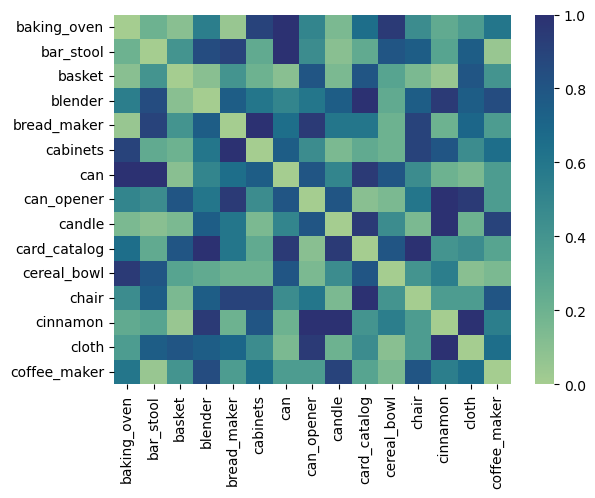

In [471]:
# counts
cooccur = np.random.randint(low=1,high=21,size=(len(full_objects),len(full_objects)))
np.fill_diagonal(cooccur,0)
cooccur = cooccur/np.max(cooccur)
cooccur = np.tril(cooccur)
cooccur = np.maximum(cooccur, cooccur.transpose())
cooccur = pd.DataFrame(cooccur,index=full_objects,columns=full_objects)

sns.heatmap(cooccur,cmap='crest')

In [472]:
# instantiate network
G = MarkovNetwork()

# create graph (add nodes and edges)
nodes = full_objects.copy()
edges = list(itertools.combinations(full_objects,r=2))

G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [479]:
# create factors
for e in G.edges():
    factor = DiscreteFactor(e, [2, 2], compatibility(e,cooccur))
    G.add_factors(factor)

In [489]:
# mrf exact inference with package
nodes = full_objects.copy()
evidence = {'blender': 1}

mrf_exact_infer(nodes,evidence)

              state
baking_oven       1
bar_stool         0
basket            0
blender           1
bread_maker       0
cabinets          0
can               0
can_opener        0
candle            0
card_catalog      0
cereal_bowl       0
chair             0
cinnamon          0
cloth             0
coffee_maker      0


In [464]:
# mrf approximate inference custom
nodes = full_objects.copy()
evidence = {'candle': 1, 'chair': 1}
iterations = 100

mrf_approx_infer(nodes,cooccur,evidence,iterations) 

baking_oven     0
bar_stool       1
basket          1
blender         0
bread_maker     1
cabinets        0
can             0
can_opener      0
candle          1
card_catalog    0
cereal_bowl     0
chair           1
cinnamon        0
cloth           0
coffee_maker    0
Name: 43, dtype: int64

In [508]:
gibbs = GibbsSampling(G)
states = [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
start_state = dict(nodes,)

gen = gibbs.sample(start_state=,size=2)

TypeError: cannot unpack non-iterable int object

In [505]:
print(gen.values)

[[1 0 1 0 0 0 0 1 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


## PART III
Below attempts the custom approximate inference algorithm on a larger (i.e., a more realistic number) set of objects to test how long it takes to run.

In [321]:
all_objs = pd.read_excel('post_objects.xlsx')
full_objects = []

for i in range(len(all_objs)):
    full_objects.append(all_objs.iloc[i][0][6:])

In [322]:
# counts
cooccur = np.random.randint(low=1,high=21,size=(len(full_objects),len(full_objects)))
np.fill_diagonal(cooccur,0)
cooccur = cooccur/np.max(cooccur)
cooccur = pd.DataFrame(cooccur,index=full_objects,columns=full_objects)

In [301]:
# mrf approximate inference custom
iterations = 10
nodes = full_objects.copy()
evidence = {'baking_oven': 1}

mrf_approx_infer(nodes,cooccur,evidence,iterations)

(baking_oven       1
 bar_stool         1
 basket            1
 blender           1
 bread_maker       1
                  ..
 trash_can         1
 tub               0
 vanity_case       0
 wash_cloth        1
 window_curtain    0
 Name: 7, Length: 97, dtype: int64,
 -8289.056137141104)